In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as pltgs
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
import time
import pandas as pd
from Hamiltonian_library import *
from Ps_library import *
from config import *
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)

In [2]:
data_handler = handler()


In [15]:
system = Ps_system()    
wavevector = 1
for i in range(50): # change number of pulses
    flip_pulse = {"rabi0" : 2*np.pi*(200e-3), "detuning": 0,"chirp" : 0,"pulse_duration" : 10,"unit_wavevector":wavevector,"start":i*30,"end":30*(1+i),"notch":1}
    #flip_pulse = {"rabi0" : 2*np.pi*(3000e-3), "detuning": 0,"chirp" : 0,"pulse_duration" : 1,"unit_wavevector":wavevector,"start":i*3,"end":3*(1+i),"notch":1}
    #flip_pulse = {"rabi0" : 2*np.pi*(500e-3), "detuning": 2*np.pi*(500e-3)*wavevector,"chirp" : 2*np.pi*(1000e-3),"pulse_duration" : 1 ,"unit_wavevector":wavevector,"start":i*3,"end":3*(1+i),"notch":1}
    flip_pulse["label"] = "laser"+str(i)
    system.init_pulse(flip_pulse)
    wavevector = -wavevector
system.init_pulse_cycle()


#system.init_distribution_singular()
#system.init_distribution_constant()
system.init_MBdistribution()
#system.init_states_ground()
system.init_states_desymmetrized()
#system.set_Hamiltonian_notched_MT3()
system.set_Hamiltonian_MT()
system.evolve()


# fig,ax = plt.subplots()
# ax.plot(system.velocity_bins,system.initial_pop,color="black")

# #system.init_MBdistribution(v0=1e-5)

# #ax.plot(system.velocity_bins[:-1],system.initial_pop[:-1],ls="dashed",color="black")
# #plt.legend(["1","2"])
# plt.ylabel("number of Ps")
# plt.xlabel("velocity [cm/ps]")
# plt.savefig("./figures/collab_meeting/cooling1.png",bbox_inches="tight")
# plt.show()

10.0%. Run time:  41.13s. Est. time left: 00:00:06:09
20.0%. Run time:  76.92s. Est. time left: 00:00:05:07
30.0%. Run time: 112.92s. Est. time left: 00:00:04:23


: 

: 

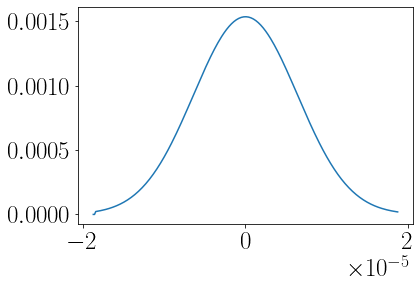

In [160]:
#print(system.e_ops[1])
plt.plot(system.velocity_bins,[system.result.expect[i][-1] for i in range(system.N_bins)])

#plt.plot(system.velocity_bins)

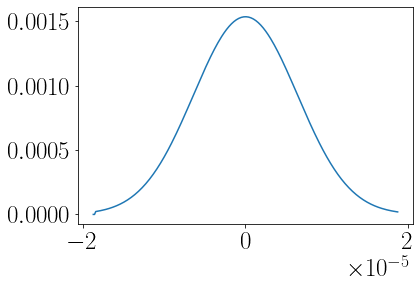

In [164]:
plt.plot(system.velocity_bins,system.get_states(system.saved_states[-1])[1])

In [17]:
N_atoms = int(1e5)
end = 50
pops = []

for j in range(end):
    system = Ps_system(N_atoms)    
    wavevector = 1
    for i in range(1): # change number of pulses
        #flip_pulse = {"rabi0" : 2*np.pi*(3000e-3), "detuning": 0,"chirp" : 2*np.pi*(4000e-3),"pulse_duration" : 1,"unit_wavevector":wavevector,"start":i*3,"end":3*(1+i),"notch":1}
        flip_pulse = {"rabi0" : 2*np.pi*(500e-3), "detuning": 2*np.pi*(50e-3*j)*wavevector,"chirp" : 2*np.pi*(500e-3),"pulse_duration" : 1 ,"unit_wavevector":wavevector,"start":i*3,"end":3*(1+i),"notch":1}
        flip_pulse["label"] = "laser"+str(i)
        system.init_pulse(flip_pulse)
        wavevector = -wavevector

    system.init_distribution_constant()
    system.init_states_ground()
    #system.init_MBdistribution()
    #system.init_states_desymmetrized()
    
    system.set_Hamiltonian_notched_MT2()
    system.evolve()
    pops.append(system.get_states(system.saved_states[1]))

KeyboardInterrupt: 

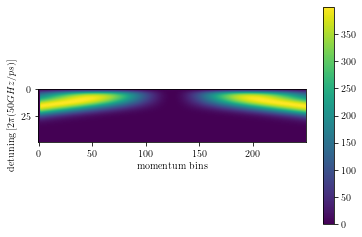

In [ ]:
#X = np.asarray([pops[i][0][80:170] for i in range(end)])
X = np.asarray([pops[i][1] for i in range(end)])
plt.imshow(X)
plt.ylabel(r"detuning [$2\pi(50 GHz/ps)$]")
plt.xlabel("momentum bins")
plt.colorbar()
#plt.savefig("./figures/nov_2022/detuning.png")

In [ ]:
system.saved_states = data_handler.load_states("./data/states/nov18")
#data_handler.save_states(system,"./data/states/notched_5ps_R240GHz_D50GHz_C100GHz")

In [ ]:
#data_handler.save_states(system,"./data/states/nov14")

In [ ]:

# N_g,N_e,N = system.get_states(system.saved_states[1])
# df = pd.DataFrame(np.asarray([N_g,N_e,N]))
# df.to_csv("excitation_profile.csv")
# print(df)
    


Text(0.5, 0, 'time [ps]')

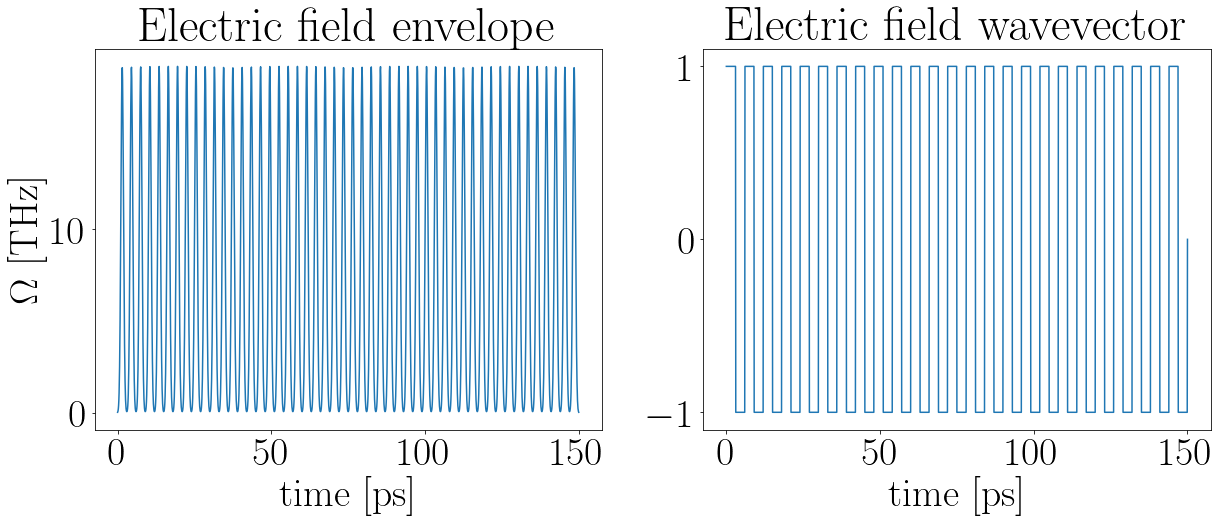

In [ ]:
nrows = 2
ncols = 2
#print(system.tlist[1]-system.tlist[0])
#print(system.chirp[1]-system.chirp[0])

# fig,axes = plt.subplots(nrows,ncols,figsize=(nrows*4,ncols*4))
# axes[0,0].plot(system.tlist,system.rabi)
# axes[0,0].set_title("rabi")
# axes[1,0].plot(system.tlist,system.chirp)
# axes[1,0].set_title("chirp")
# axes[0,1].plot(system.tlist,system.wavevector)
# axes[0,1].set_title("wavevector")
# axes[1,1].plot(system.tlist,system.func1,system.tlist,system.func2)

fig,axes = plt.subplots(1,2,figsize=(20,7))
axes[0].plot(system.tlist,system.rabi)
axes[1].plot(system.tlist,system.wavevector)

axes[0].set_title("Electric field envelope")
axes[1].set_title("Electric field wavevector")
axes[0].set_ylabel(r"$\Omega$ [THz]")
axes[0].set_xlabel("time [ps]")
axes[1].set_xlabel("time [ps]") 

#plt.savefig("./figures/nov_2022/efield.jpg",bbox_inches="tight")

In [ ]:
# def get_entropy(system,states):
#         entropy = 0
#         for i in range(2*system.N_bins):
#                 pop = np.abs(states[i,i])
#                 if pop > 0:
#                         entropy += -k*pop*np.log(pop)
#         return entropy

def get_entropy(system,states):
        N_g,N_e,N = system.get_states(states.unit())
        selector_g = N_g > 0
        selector_e = N_e > 0
        selector_t = N > 0
        S_g = k*np.sum(-np.asarray(N_g[selector_g])*np.log(np.asarray(N_g[selector_g]))) # eV/K
        S_e = k*np.sum(-np.asarray(N_e[selector_e])*np.log(np.asarray(N_e[selector_e]))) # eV/K
        S_t = k*np.sum(-np.asarray(N[selector_t])*np.log(np.asarray(N[selector_t]))) # eV/K
        return S_g,S_e,S_t

entropy = np.asarray([get_entropy(system,states.unit()) for states in system.saved_states])
pulses_arr = np.arange(51)

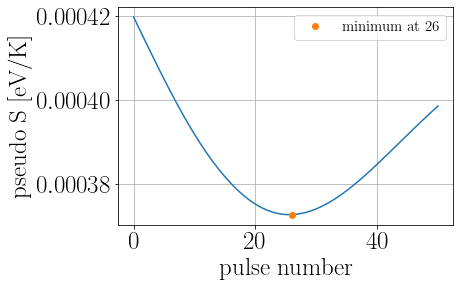

In [ ]:
#plt.plot(pulses_arr,entropy[:,0],label="S_g")
#plt.plot(pulses_arr,entropy[:,1],label="S_e")
plt.plot(pulses_arr,entropy[:,2])
#plt.plot(pulses_arr,entropy[:,0]+entropy[:,1],label="total")
#plt.plot(pulses_arr,entropy)
min = np.amin(entropy[:,2])
min_idx = np.argmin(entropy[:,2])
plt.plot(min_idx,min,'o',label="minimum at {}".format(min_idx))
plt.legend(fontsize=15)
plt.xlabel("pulse number")
plt.ylabel("pseudo S [eV/K]")
plt.grid()
plt.savefig("./figures/nov_2022/entropy3.png",bbox_inches="tight")
plt.show()


In [ ]:
time = 0
checkpoints = [time]
idxs = [0]
for laser in system.laserDict:
    time = laser[1].endTime
    checkpoints.append(time)
    idxs.append(int(time/system.dt))

In [ ]:
omega_recoil = 0.5*hbar*hbar_eV*system.wavenumber_value**2/(system.m/c**2) # 1/ps   
chirp = 37
U = []
i=0
KE = np.arange(-system.N_bins//2,system.N_bins//2)**2*hbar_eV*omega_recoil
for idx in idxs:   
    N_g,N_e,N = system.get_states(system.saved_states[i].unit())
    #H = qt.tensor(qt.qeye(system.N_bins),qt.Qobj([[0,0],[0,hbar_eV*chirp]]))
    #H = qt.tensor(qt.qeye(system.N_bins),qt.Qobj([[0,0],[0,hbar_eV*chirp]]))
    #H2 = (qt.tensor(qt.num(system.N_bins,offset=-system.N_bins//2),qt.qeye(2)))**2*hbar_eV*omega_recoil
    #M = rho*(H2)
    #U.append(np.abs(np.sum([M[i,i] for i in range(2*system.N_bins)])))
    U.append(np.sum(N*KE))
    i+=1
# i =0
# U = []
# for idx in idxs:
#     rho = system.saved_states[i].unit() 
#     H = qt.tensor(qt.qzero(system.N_bins),qt.qeye(2))
#     for A in system.H:
#         if type(A) == list:
#             H = H+ A[0]*A[1][idx]
#         else:
#             H = H+A
#     KE = (qt.tensor(qt.num(system.N_bins,offset=-system.N_bins//2),qt.qeye(2)))**2*hbar_eV*omega_recoil
#     U.append(np.abs(np.sum([(rho*(H+KE))[i,i] for i in range(2*system.N_bins)])))
#     i +=1
#print(len(U))


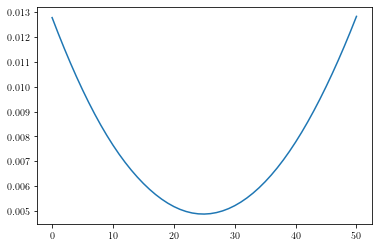

In [ ]:
pulses_arr = np.arange(51)
plt.plot(pulses_arr,U)

[210.47281205 202.76683702 195.7739167  189.45026629]


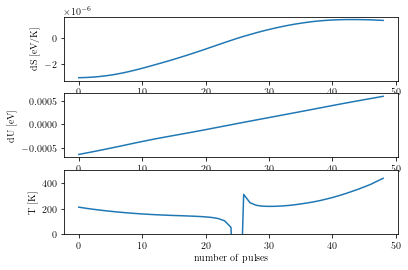

In [ ]:
S_pseudo = entropy[:-1,2] 

dS = np.asarray([(S_pseudo[i+1]-S_pseudo[i]) for i in range(len(idxs)-2)])
dU = np.asarray([(U[i+1]-U[i]) for i in range(len(idxs)-2)])
T = dU/dS
print(T[0:4])
pulses_arr = np.arange(49)
fig,axes = plt.subplots(3)
axes[0].plot(pulses_arr,dS)
axes[0].set_ylabel("dS [eV/K]")
axes[1].plot(pulses_arr,dU)
axes[1].set_ylabel("dU [eV]")
#axes[1].set_xlim(25,30)
axes[2].plot(pulses_arr,T)
axes[2].set_ylabel("T [K]")
axes[2].set_ylim(0,500)
axes[2].set_xlabel("number of pulses")
#plt.savefig("./figures/nov_2022/temps1.jpg")


In [ ]:
sigmas = np.zeros(51)
for j in range(51):
    N_g,N_e,N = system.get_states(system.saved_states[j].unit())
    #sigmas[j] = np.sqrt(np.sum([p_i*v_i**2 for (p_i,v_i) in [(N[i],system.velocity_bins[i]) for i in range(system.N_bins)] ]))
    #sigmas[j] = np.std(N)


31.80850235263849


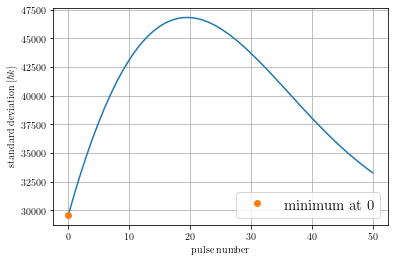

In [ ]:


print(system.std_deviation/1.5e-7)
plt.plot(np.arange(51),sigmas/1.5e-7)
#print(np.min(sigmas))
min = np.amin(sigmas)
min_idx = np.argmin(sigmas)
plt.plot(min_idx,min/1.5e-7,'o',label="minimum at {}".format(min_idx))
plt.legend(fontsize=15)
plt.xlabel("pulse number")
plt.ylabel(r"standard deviation [$\hbar k$]")
#plt.xlim(22,27)
plt.grid()
#plt.savefig("./figures/nov_2022/standard_deviation2.png",bbox_inches="tight")

In [ ]:
#data_handler.save_states(system,"./data/states/R500GHz_D0_C200GHzps_50pulses")

Quantum object: dims = [[250, 2], [250, 2]], shape = (500, 500), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


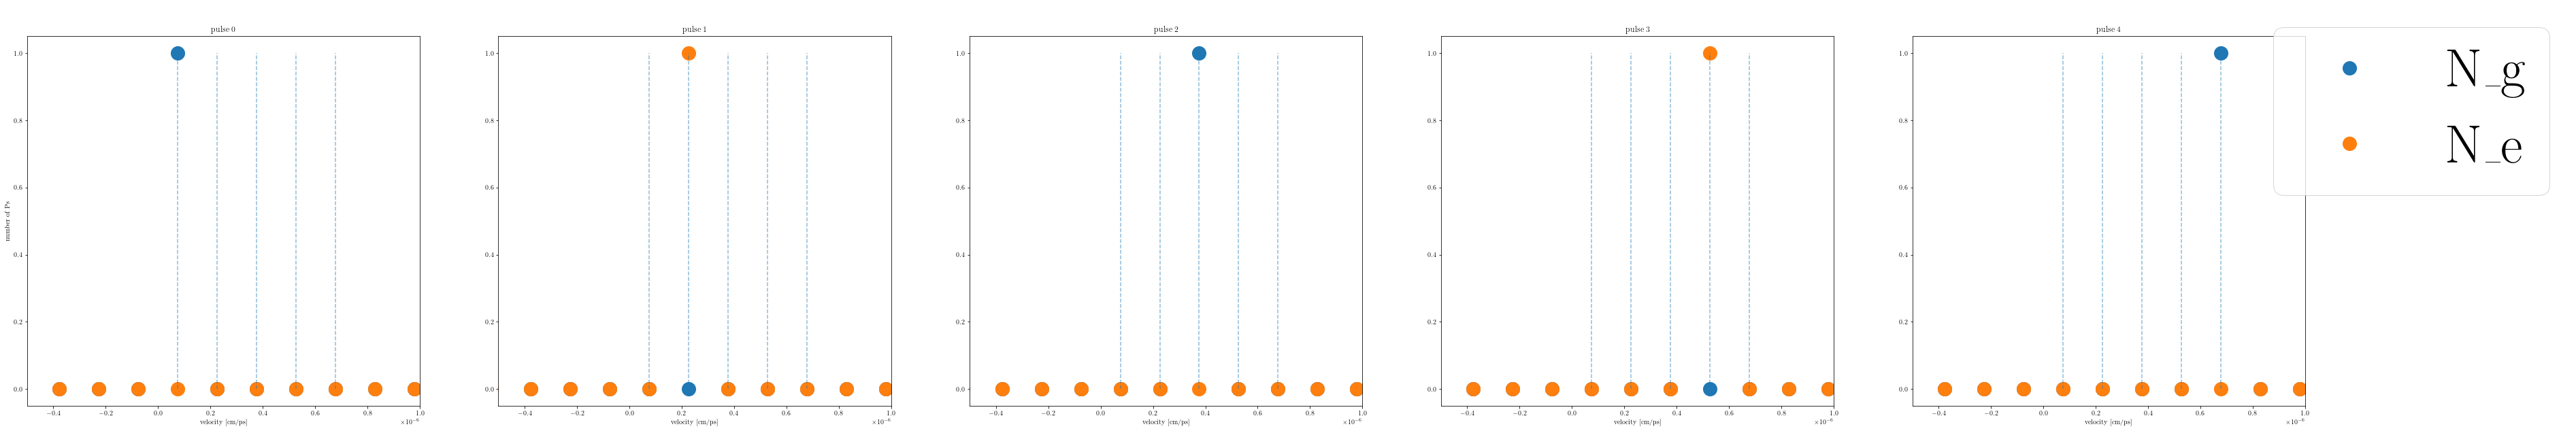

In [ ]:

xaxis = system.velocity_bins
#xaxis_twin = axes[0].twinx()
#
N_diagrams = 5
N_pulses = 5
# # #plt.xlabel("momen cm/ps")
# # #print(system.saved_states)
fig,axes = plt.subplots(1,N_diagrams,figsize=(12*N_diagrams,10))
step = N_pulses//N_diagrams
# print(step)
j= 0
for i in range(N_pulses):
    if i % step == 0:
        N_g,N_e,N = system.get_states(system.saved_states[i])
        axes[j].plot(xaxis,N_g,'.',label="N_g",markersize=40)
        axes[j].plot(xaxis,N_e,'.',label="N_e",markersize=40)
        #axes[j].plot(xaxis,N,'.',label="total",markersize=12)
        
        axes[j].vlines(xaxis[system.N_bins//2:system.N_bins//2+N_pulses],0,1,alpha=0.5,ls="dashed")

        axes[j].set_xlabel("velocity [cm/ps]")
        axes[j].set_title("pulse"+" " + str(i))
        
        axes[j].set_xlim(-0.5e-6,1e-6)
        j +=1
fig.legend(["N_g","N_e"],fontsize=80)
axes[0].set_ylabel("number of Ps")

plt.savefig("./figures/nov_2022/momentum_transfer_doppler4.jpg",bbox_inches="tight")
#print(system.saved_states[1])
# fig, axes = plt.subplots(2,figsize=(7,14))
# N_g,N_e,N = system.get_states(system.saved_states[0])
# axes[0].plot(xaxis,N_g,'.',label="N_g")
# axes[0].plot(xaxis,N_e,'.',label="N_e")
# #axes[0].plot(xaxis,N)
# axes[0].legend(fontsize=15)
# #axes[0].set_xlim(-2e-6,2e-6)
# #plt.savefig("./figures/nov_2022/velocity_profile.jpg")
# N_g,N_e,N = system.get_states(system.saved_states[-1])
# #axes[1].plot(xaxis,N_g,'.',label="N_g")
# #axes[1].plot(xaxis,N_e,'.',label="N_e")
# axes[1].plot(xaxis,N,'.',label="total")
# axes[1].legend(fontsize=15)
# axes[1].set_xlabel("vel [cm/ps]")
# axes[1].set_ylabel("Population")
#axes[1].set_xlim(-2e-6,2e-6)

#plt.savefig("./figures/nov_2022/pulse22.jpg",bbox_inches="tight")
# excited = system.get_excited()
# ground = system.get_ground()
# fig,ax = system.get_initial_pop_plot()

# ax.plot(system.velocity_bins,ground,'.',color="black",label="ground")
# ax.plot(system.velocity_bins,excited,'.',color="orange",label="excited")
# #ax.legend()
# ax.set_xlim(-2e-6,2e-6)
# #ax.set_ylim(0,100)
# #plt.savefig("figures/cmt/test_MT_2pulses.jpg")
# plt.show()
# print(excited[system.N_bins//2+1],ground[system.N_bins//2+2],system.initial_pop[system.N_bins//2])

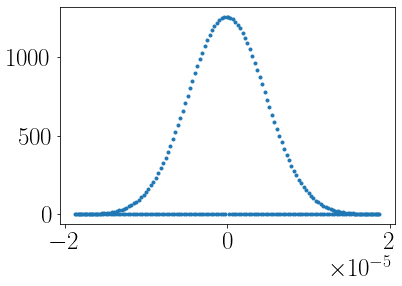

KeyboardInterrupt: 

In [ ]:
N_g,N_e,N = system.get_states(system.saved_states[0])
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(system.velocity_bins,N,'.')
for states in system.saved_states:
    N_g,N_e,N = system.get_states(states)
    line1.set_ydata(N)
    fig.canvas.draw()
    plt.show(fig)
    fig.canvas.flush_events()
    #time.sleep(1)

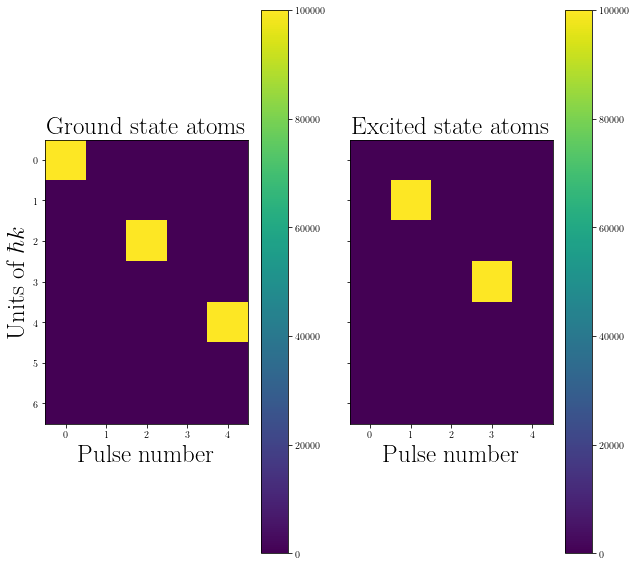

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,10),sharey=True)
X = np.zeros((5,7))
X2 = np.zeros((5,7))
#X = np.zeros((5,system.N_bins))
for i in range(5):
    N_g,N_e,N = system.get_states(system.saved_states[i])
    X[i] = N_g[system.N_bins//2:system.N_bins//2+7]
    X2[i] = N_e[system.N_bins//2:system.N_bins//2+7]

im = axes[0].imshow(X.T)
im2 = axes[1].imshow(X2.T)
plt.colorbar(im,ax=axes[0])
plt.colorbar(im2,ax=axes[1])
axes[0].set_title("Ground state atoms",fontsize=25)
axes[1].set_title("Excited state atoms",fontsize=25)
axes[0].set_xlabel("Pulse number",fontsize=25)
axes[1].set_xlabel("Pulse number",fontsize=25)
axes[0].set_ylabel(r"Units of $\hbar k$",fontsize=25)
#plt.savefig("./figures/collab_meeting/gradient.png",bbox_inches="tight")

In [75]:
fig = plt.figure()
plt.gridspec.gridspec(5,2)
#print(np.asarray(system.saved_states).shape)
pops = np.zeros(50)
for i in range(50):
    N_g,N_e,N = system.get_states(system.saved_states[i])
    pops[i] = N[system.N_bins//2]
plt.plot([i for i in range(50)], pops)
plt.title("Population of Ps at v=0")
plt.xlabel("num of pulses")
plt.ylabel("number of atoms")
#plt.savefig("./figures/cmt/pop_at_zero_vel.jpg",bbox_inches="tight")

AttributeError: module 'matplotlib.pylab' has no attribute 'gridspec'

<Figure size 432x288 with 0 Axes>

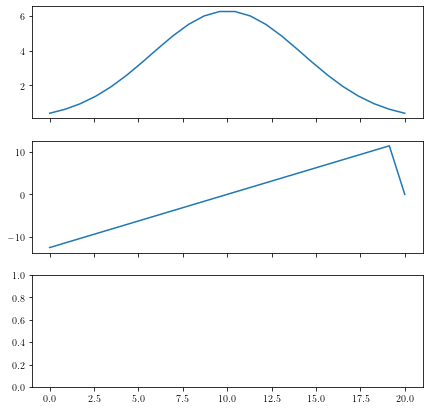

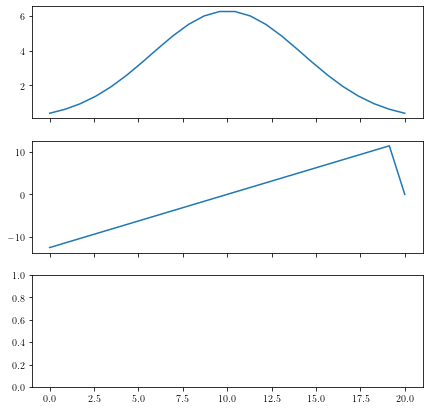

In [ ]:
for laser in system.laserDict:
    laserObj = laser[1]    
    fig,axes = plt.subplots(2,sharex=True,figsize=(7,7))
    axes[0].plot(laserObj.tlist,laserObj.rabi(laserObj.tlist,None))
    #axes[0].set_ylabel(r"$\Omega$ [THz]")
    axes[1].plot(laserObj.tlist,laserObj.chirp(laserObj.tlist,None))
    #axes[1].set_ylabel("r$\alpha$ [THz/ps]")
    #axes[2].plot(laserObj.tlist,laserObj.wavevector)
    #axes[2].set_ylabel("k")
    #axes[2].set_xlabel("time [ps]")
    plt.show()           

KeyError: 0

# Multiple trains of pulses

In [ ]:
N_atoms = int(1e5)
system = Ps_system(N_atoms)

system.init_MBdistribution()
system.init_states_desymmetrized()

N_pulses = 2
wavevector = 1
for i in range(N_pulses): # change number of pulses
    flip_pulse = {"rabi0" : 2*np.pi*(3000e-3), "detuning": 0,"chirp" : 2*np.pi*(4000e-3),"pulse_duration" : 1,"unit_wavevector":wavevector,"start":i*3,"end":3*(1+i),"notch":1}
    flip_pulse["label"] = "laser"+str(i)
    system.init_pulse(flip_pulse)
    wavevector = -wavevector
system.init_pulse_cycle()

N_trains = 16
for i in range(N_trains):    
    system.set_Hamiltonian_MT2()
    system.evolve()
    system.reset_distribution(system.saved_states[-1])

#data_handler.save_states(system,"./data/trains/2_pulses_16_trains.csv")


10.8%. Run time:   5.14s. Est. time left: 00:00:00:42
20.3%. Run time:  10.02s. Est. time left: 00:00:00:39
31.1%. Run time:  15.54s. Est. time left: 00:00:00:34
40.5%. Run time:  20.42s. Est. time left: 00:00:00:29
50.0%. Run time:  27.69s. Est. time left: 00:00:00:27
60.8%. Run time:  37.22s. Est. time left: 00:00:00:23
70.3%. Run time:  40.24s. Est. time left: 00:00:00:17
81.1%. Run time:  44.01s. Est. time left: 00:00:00:10
90.5%. Run time:  47.18s. Est. time left: 00:00:00:04
Total run time:  52.90s
10.8%. Run time:   5.80s. Est. time left: 00:00:00:47
20.3%. Run time:  10.38s. Est. time left: 00:00:00:40
31.1%. Run time:  15.12s. Est. time left: 00:00:00:33
40.5%. Run time:  19.66s. Est. time left: 00:00:00:28
50.0%. Run time:  27.14s. Est. time left: 00:00:00:27
60.8%. Run time:  34.76s. Est. time left: 00:00:00:22
70.3%. Run time:  37.62s. Est. time left: 00:00:00:15
81.1%. Run time:  40.49s. Est. time left: 00:00:00:09
90.5%. Run time:  43.63s. Est. time left: 00:00:00:04
Tota

In [ ]:
system.saved_states = data_handler.load_states("./data/trains/16_pulses_16_trains.csv")

In [ ]:
print(len(system.saved_states))
#std = data_handler.get_std(system)
#std = std/1.5e-7

272


In [31]:
system = Ps_system(1e5)

N_pulses = [2,4,8,16]
N_trains = 16
N_points = 272
extended_std = np.zeros((5,N_points))
std = []
for i in range(4):
    N_zeros = 16-N_pulses[i]
    system.saved_states = data_handler.load_states("./data/trains/{}_pulses_16_trains.csv".format(N_pulses[i]))
    std.append(data_handler.get_std(system)/1.5e-7)
    #std = data_handler.get_std(system)/1.5e-7  
    #xaxis = np.arange(N_pulses[i]+1) + np.asarray(([j*17 for j in range(N_trains)]*(N_pulses[i]+1)).sort())

    # ls = []
    # for j in range(N_trains):
    #     for k in range(N_pulses[i]+1):
    #         ls.append(std[k+j*N_pulses[i]])
    #         last = std[k+j*N_pulses[i]]
    #     for k in range(16-N_pulses[i]):
    #         ls.append(last)
    # extended_std[i] = np.asarray(ls)
        
    
# spontaneous emission
last = 32
ls = []
for j in range(N_trains):
    for k in range(17):
        ls.append(last-j)
std.append(np.asarray(ls))

48
80
144
272


In [26]:
# algorithm: take array of N_points length. Expand array such that each 17th element is a new sequence. From each sequence remove 17-N_pulses[i] datapoints. Concatenate.
#N_points = 272
#N_trains = 16
xaxis = []
for i in range(3):
    xaxis.append(np.hstack((np.reshape(np.arange(N_points),(N_trains,17)))[:,:N_pulses[i]+1]))
xaxis.append(np.arange(N_points))

print(xaxis[1])



[  0   1   2   3   4  17  18  19  20  21  34  35  36  37  38  51  52  53
  54  55  68  69  70  71  72  85  86  87  88  89 102 103 104 105 106 119
 120 121 122 123 136 137 138 139 140 153 154 155 156 157 170 171 172 173
 174 187 188 189 190 191 204 205 206 207 208 221 222 223 224 225 238 239
 240 241 242 255 256 257 258 259]


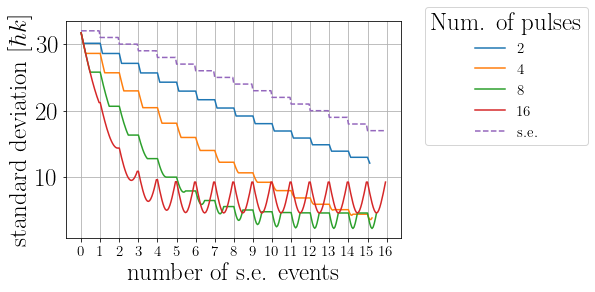

In [55]:
xaxis.append(np.arange(N_points))
fig,ax = plt.subplots()
labels = [N_pulses[0],N_pulses[1],N_pulses[2],N_pulses[3],"s.e."]
lss = ['-','-','-','-','dashed']
for i in range(5):  
    #ax.plot(np.arange(N_points),extended_std[i],label=labels[i],ls=lss[i])
    #ax.plot(np.arange(N_trains*(N_pulses[i]+1)),std[i],label=labels[i],ls=lss[i])
    ax.plot(xaxis[i],std[i],label=labels[i],ls=lss[i])

plt.xlabel("number of s.e. events",fontsize=25)
plt.ylabel(r"standard deviation [$\hbar k$]",fontsize=25)
plt.legend(fontsize=15,title="Num. of pulses",bbox_to_anchor=(1.05,1.1))
plt.xticks(np.asarray([17*i for i in range(N_trains+1)]),np.arange(17),fontsize=15)
#plt.xlim()

plt.grid()
#plt.savefig("./figures/nov_2022/standard_deviation_trains_extended.png",bbox_inches="tight")
plt.show()

In [34]:
ls = [1]
ls.append([0])
print(ls)

[1, [0]]


# Notched spectra

In [4]:
for j in range(10):
    system = Ps_system(1)    
    #tau = 2*hbar*omega0/flip_pulse["chirp"]
    #width = 2*np.pi/tau

    flip_pulse = {"rabi0" : 2*np.pi*(1000e-3), "detuning": 0,"chirp" : 2*np.pi*(50e-3),"pulse_duration" : j+1,"unit_wavevector":1,"start":0,"end":3*(j+1),"notch":1e-6}
    flip_pulse["label"] = "laser"+str(1)
    system.init_pulse(flip_pulse)
    system.init_pulse_cycle()

    #print("{:.5f}THz".format(width))
    #print("{:.5f}THz".format(flip_pulse["detuning"]))

    #print(system.rabi_beating2)
    #system.init_distribution_singular()
    system.init_distribution_constant()
    #system.init_MBdistribution()
    system.init_states_ground()
    #system.init_states_desymmetrized()
    system.set_Hamiltonian_notched_MT3()
    system.evolve()
    #data_handler.save_states_csv(system,"./data/states_notched/tau/R{:.5f}_CR{:.5f}_T{:.3f}_N{:.5e}".format(flip_pulse["rabi0"],flip_pulse["chirp"],flip_pulse["pulse_duration"],flip_pulse["notch"]))


10.8%. Run time:   0.34s. Est. time left: 00:00:00:02
21.6%. Run time:   0.49s. Est. time left: 00:00:00:01
32.4%. Run time:   0.88s. Est. time left: 00:00:00:01
40.5%. Run time:   1.15s. Est. time left: 00:00:00:01
51.4%. Run time:   1.55s. Est. time left: 00:00:00:01
62.2%. Run time:   1.91s. Est. time left: 00:00:00:01
70.3%. Run time:   2.15s. Est. time left: 00:00:00:00
81.1%. Run time:   2.27s. Est. time left: 00:00:00:00
91.9%. Run time:   2.50s. Est. time left: 00:00:00:00
Total run time:   2.72s
10.8%. Run time:   0.51s. Est. time left: 00:00:00:04
20.3%. Run time:   0.83s. Est. time left: 00:00:00:03
31.1%. Run time:   1.22s. Est. time left: 00:00:00:02
40.5%. Run time:   1.62s. Est. time left: 00:00:00:02
50.0%. Run time:   1.91s. Est. time left: 00:00:00:01
60.8%. Run time:   2.36s. Est. time left: 00:00:00:01
70.3%. Run time:   2.77s. Est. time left: 00:00:00:01
81.1%. Run time:   3.36s. Est. time left: 00:00:00:00
90.5%. Run time:   3.58s. Est. time left: 00:00:00:00
Tota

KeyboardInterrupt: 

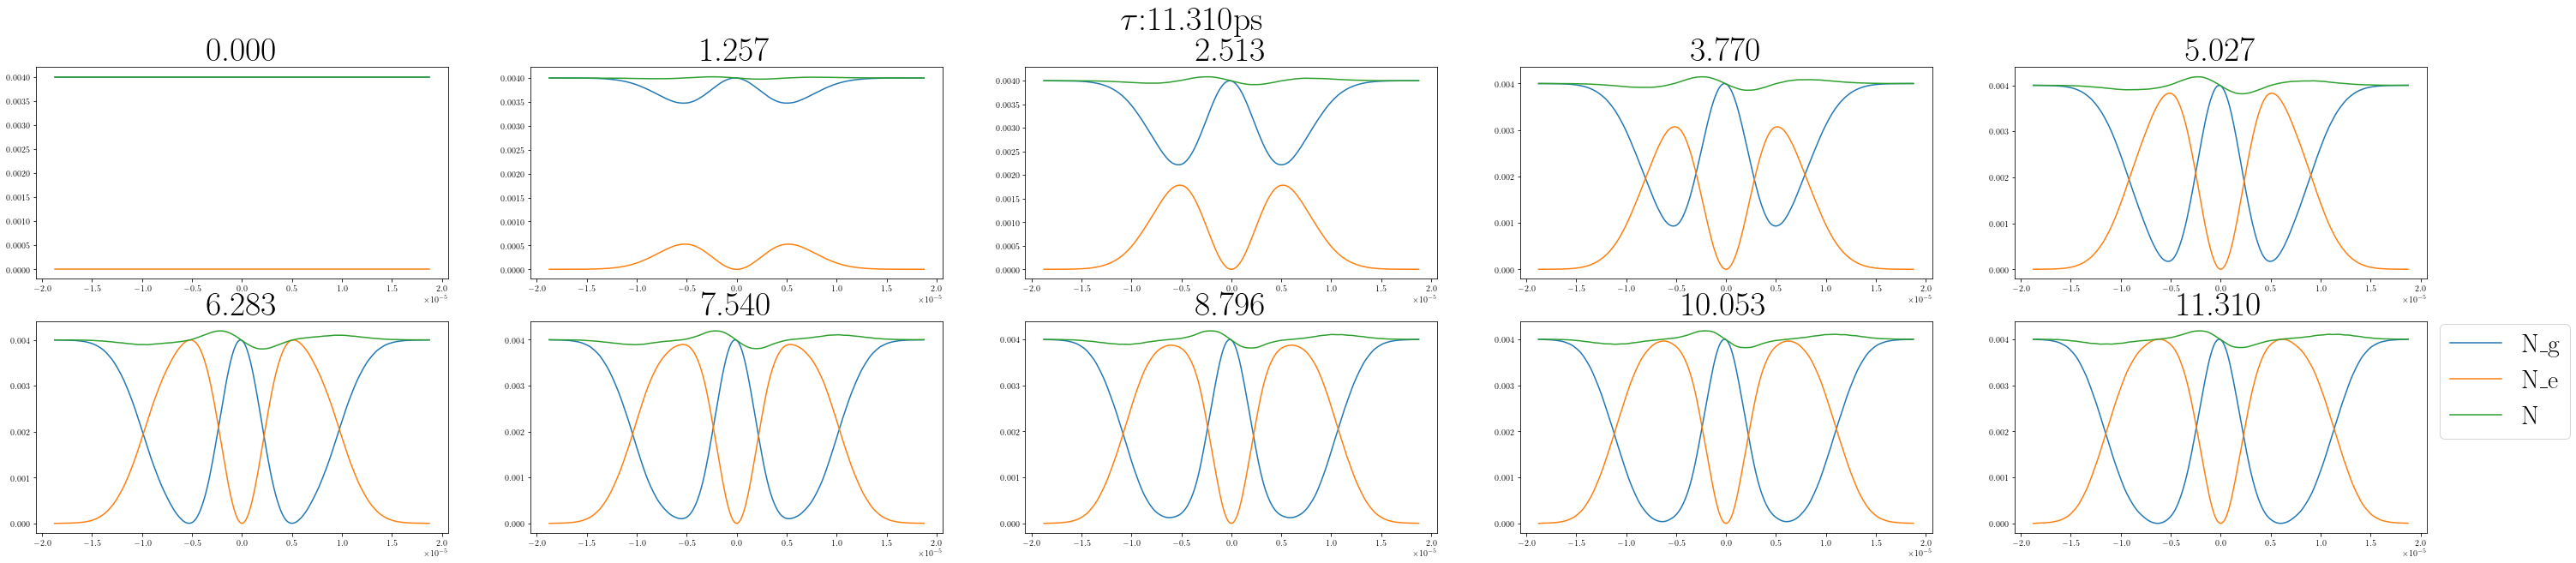

In [19]:
fig,axes = plt.subplots(2,5,figsize=(5*10,10))
labels=[]

axes = np.ravel(axes)
for i in range(10):
    notch = 1e-6
    chirp = 2*np.pi*(50e-3)
    rabi0 = 2*np.pi*(200e-3)*i
    system.saved_states = data_handler.load_states_csv("./data/states_notched/rabi0/R{:.5f}_CR{:.5f}_T{:.3f}_N{:.5e}".format(rabi0,chirp,flip_pulse["pulse_duration"],notch))
    N_g,N_e,N = system.get_states(system.saved_states[-1])
    axes[i].plot(system.velocity_bins,N_g)
    axes[i].plot(system.velocity_bins,N_e)
    axes[i].plot(system.velocity_bins,N)
    axes[i].set_title("{:.3f}".format(rabi0),fontsize=40)

axes = np.reshape(axes,(2,5))
plt.suptitle(r"$\tau$:{:.3f}ps".format(flip_pulse["rabi0"],flip_pulse["pulse_duration"]),fontsize=40)
plt.legend([r"N_g",r"N_e","N"],fontsize=30,bbox_to_anchor=(1,1.05))
#plt.savefig("./figures/notched/change_in_rabi.png")
plt.show()

[('laser0', <Ps_library.laser object at 0x7fa975719060>)]


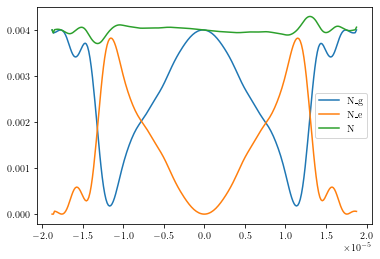

# Cooling with notched spectra

In [3]:
N_atoms = int(1e5)
system = Ps_system(N_atoms)
system.init_MBdistribution()
system.init_states_desymmetrized()

N_pulses = 30
wavevector = 1
for i in range(N_pulses): # change number of pulses
    flip_pulse = {"rabi0" : 2*np.pi*(1000e-3), "detuning": 0,"chirp" : 2*np.pi*(50e-3),"pulse_duration" : 10,"unit_wavevector":wavevector,"start":i*30,"end":30*(1+i),"notch":1e-6}
    flip_pulse["label"] = "laser"+str(i)
    system.init_pulse(flip_pulse)
    wavevector = -wavevector
system.init_pulse_cycle()

system.set_Hamiltonian_notched_MT3()
system.evolve()




10.0%. Run time: 279.40s. Est. time left: 00:00:41:52
20.0%. Run time: 563.67s. Est. time left: 00:00:37:34


: 

: 

In [7]:
data_handler.save_states_csv(system,"./data/states_notched/onepulse.csv")

In [8]:
sigmas = np.zeros(N_pulses)
for j in range(N_pulses):
    N_g,N_e,N = system.get_states(system.saved_states[j].unit())
    sigmas[j] = np.sqrt(np.sum([p_i*v_i**2 for (p_i,v_i) in [(N[i],system.velocity_bins[i]) for i in range(system.N_bins)] ]))

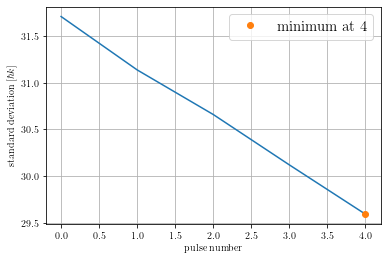

In [10]:
plt.plot(np.arange(N_pulses),sigmas/1.5e-7)
#print(np.min(sigmas))
min = np.amin(sigmas)
min_idx = np.argmin(sigmas)
plt.plot(min_idx,min/1.5e-7,'o',label="minimum at {}".format(min_idx))
plt.legend(fontsize=15)
plt.xlabel("pulse number")
plt.ylabel(r"standard deviation [$\hbar k$]")
#plt.xlim(22,27)
plt.grid()
#plt.savefig("./figures/des_2022/cooling_notched_5pulses.png",bbox_inches="tight")

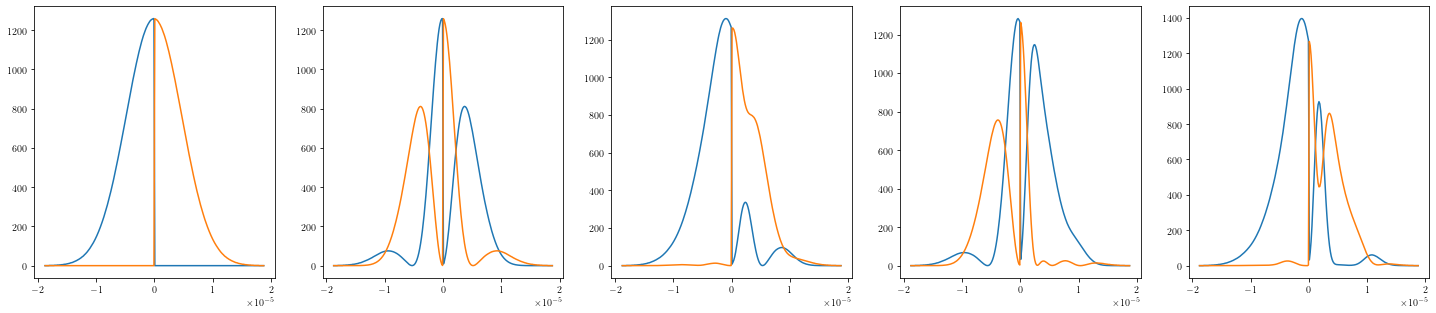

In [4]:

fig,axes = plt.subplots(1,5,figsize=(25,5))

axes = np.ravel(axes)
for i in range(5):
    N_g,N_e,N = system.get_states(system.saved_states[i])
    axes[i].plot(system.velocity_bins,N_g)
    axes[i].plot(system.velocity_bins,N_e)
    #axes[i].plot(system.velocity_bins,N_e)

axes = np.reshape(axes,(1,5))
plt.show()

# Using Krotov's algorithm to find the optimal desymmetrization pulse

In [67]:
system = Ps_system()
flip_pulse = {"label": "pulse","rabi0" : 2*np.pi*(1000e-3), "detuning": 0,"chirp" : 2*np.pi*(500e-3),"pulse_duration" : 1,"unit_wavevector":1,"start":0,"end":3,"notch":1}
system.init_pulse(flip_pulse)
system.init_pulse_cycle()

system.init_MBdistribution()
system.set_Hamiltonian_Optimization(system.chirp,system.rabi,flip_pulse["detuning"])
initial_DM = system.init_states_ground(ret=True)
target_DM = system.init_states_desymmetrized(ret=True)
objective = krotov.Objective(initial_state= initial_DM,
                        target = target_DM,
                        H = system.H)

def S(t):
    return krotov.shapes.flattop(
        t,t_start=0,t_stop=flip_pulse["end"],t_rise=0.1,t_fall=0.1,func="blackman"
    )

pulse_options = {
    id(system.H[1][1]): dict(lambda_a=1,update_shape=S),
    id(system.H[2][1]): dict(lambda_a=1,update_shape=S)
}

In [68]:
optimal_result = krotov.optimize_pulses(
    [objective],
    pulse_options,
    system.tlist,
    propagator=krotov.propagators.DensityMatrixODEPropagator(atol=1e-10, rtol=1e-8),
    chi_constructor=krotov.functionals.chis_ss
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3',name="J_T"),
        krotov.convergence.check_monotonic_error
    )
)

ValueError: Incorrect specification of time-dependent Liouvillian